In [118]:
import xml.etree.ElementTree as ET
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
import numpy as np

In [119]:
def parse_cvat_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    annotations = defaultdict(list)

    for image in root.findall('image'):
        image_path = image.get('name')
        
        for polygon in image.findall('polygon'):
            item_name = polygon.get('label')
            points = polygon.get('points')
            points_list = [tuple(map(float, point.split(','))) for point in points.split(';')]

            annotation = {
                'item_name': item_name,
                'polygon': points_list,
                'image_path': image_path
            }
            annotations[annotation['item_name']].append(annotation)

    return annotations

# Example usage


In [120]:
xml_file = str(Path(r'C:\Users\mIkhail7975\Desktop\coins\annotations.xml'))
annotations = parse_cvat_annotations(xml_file)


In [121]:
annotations['1_ruble']

[{'item_name': '1_ruble',
  'polygon': [(666.0, 6.0),
   (626.0, 2.0),
   (600.0, 3.0),
   (570.0, 9.0),
   (539.0, 20.0),
   (513.0, 36.0),
   (487.0, 59.0),
   (463.0, 93.0),
   (450.0, 121.0),
   (443.0, 154.0),
   (442.0, 196.0),
   (449.0, 231.0),
   (463.0, 265.0),
   (474.0, 279.0),
   (476.0, 285.0),
   (504.0, 314.0),
   (525.0, 329.0),
   (565.0, 347.0),
   (588.0, 352.0),
   (634.0, 351.0),
   (674.0, 342.0),
   (707.0, 328.0),
   (743.0, 300.0),
   (763.0, 277.0),
   (782.0, 241.0),
   (788.0, 221.0),
   (790.0, 205.0),
   (793.0, 199.0),
   (794.0, 181.0),
   (796.0, 179.0),
   (797.0, 152.0),
   (795.0, 150.0),
   (796.0, 141.0),
   (792.0, 138.0),
   (793.0, 131.0),
   (790.0, 121.0),
   (784.0, 113.0),
   (782.0, 99.0),
   (759.0, 64.0),
   (739.0, 44.0),
   (705.0, 21.0),
   (683.0, 11.0)],
  'image_path': '1-rubl-1998-goda-6.jpg'},
 {'item_name': '1_ruble',
  'polygon': [(806.0, 33.0),
   (784.0, 40.0),
   (760.0, 43.0),
   (721.0, 59.0),
   (678.0, 64.0),
   (657.0, 

In [122]:
ann = annotations['1_ruble'][0]

In [123]:
annotations.keys()

dict_keys(['tail', '5_ruble', '5', 'eagle', '1', '1_ruble', '10_ruble', '0', '2_ruble', '2'])

In [130]:
def cut_polygon_from_image(image, polygon_points):
    # Create a mask for the polygon
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(polygon_points, dtype=np.int32)], 255)

    # Extract the polygon area from the image
    polygon_area = cv2.bitwise_and(image, image, mask=mask)

    # Crop the bounding box around the polygon
    x, y, w, h = cv2.boundingRect(np.array(polygon_points, dtype=np.int32))
    cropped_polygon = polygon_area[y:y+h, x:x+w]

    return cropped_polygon, (w, h)

def paste_polygon_on_image(base_image, polygon_image, position):
    x, y, = position
    h, w, _ = polygon_image.shape

    # Ensure the polygon fits within the base image
    if x + w > base_image.shape[1] or y + h > base_image.shape[0]:
        raise ValueError(f"Polygon does not fit within the base image at the given position:\n"
                         f"X: {x + w} vs {base_image.shape[1]}\n"
                         f"Y: {y + h} vs {base_image.shape[0]}")

    # Create a mask for the polygon image
    mask = cv2.cvtColor(polygon_image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
    result_image = base_image.copy()
    # Define the region of interest on the base image
    roi = result_image[y:y+h, x:x+w]

    # Blend the polygon image onto the base image
    roi_bg = cv2.bitwise_and(roi, roi, mask=cv2.bitwise_not(mask))
    polygon_fg = cv2.bitwise_and(polygon_image, polygon_image, mask=mask)
    combined = cv2.add(roi_bg, polygon_fg)

    # Place the combined image back into the base image
    result_image[y:y+h, x:x+w] = combined

    return result_image

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result


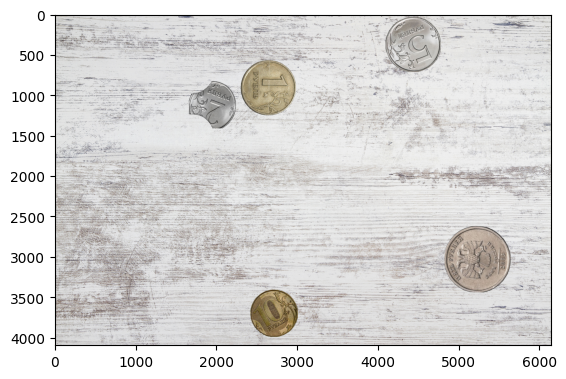

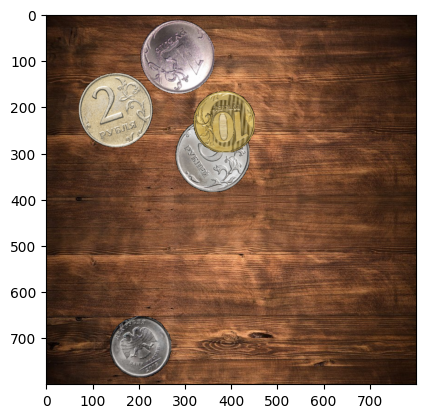

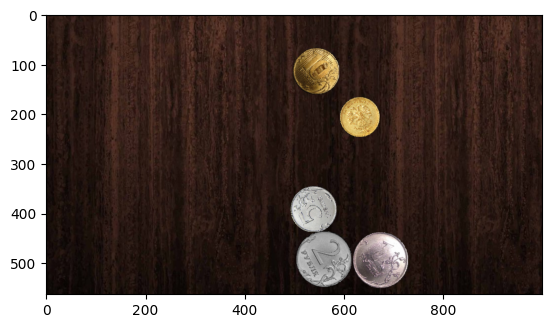

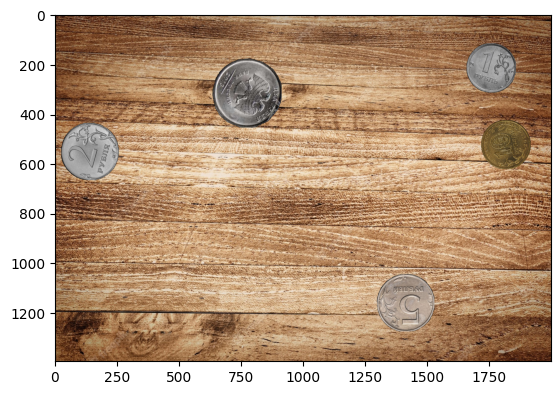

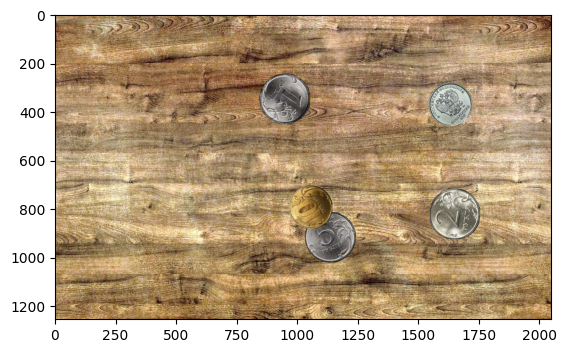

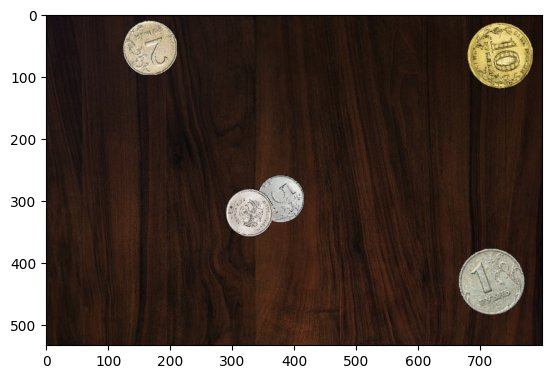

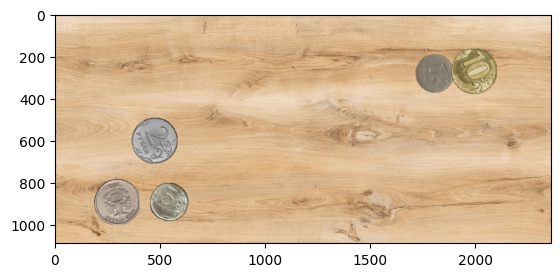

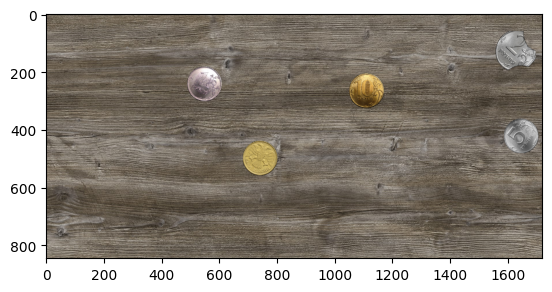

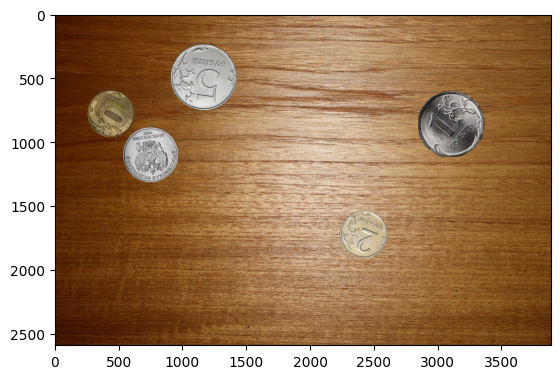

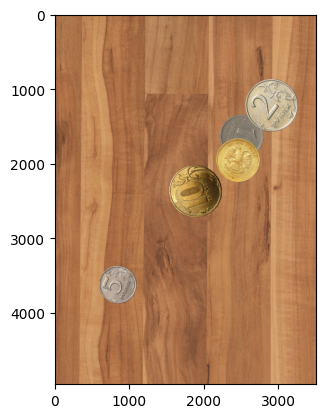

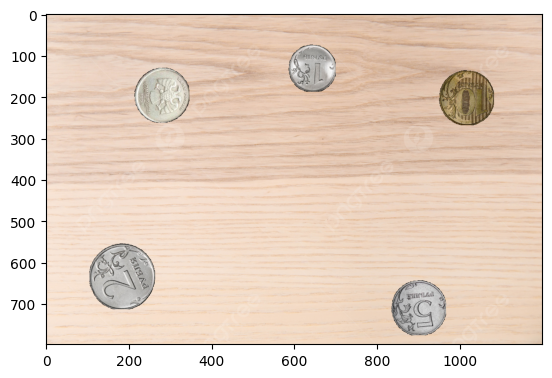

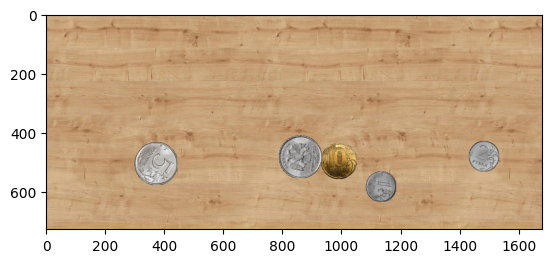

In [131]:
bg_images = list(Path(r"C:\Users\mIkhail7975\Desktop\coins\backgrounds").glob("*.jpg"))
MONEY_KEYS = ['1_ruble', '2_ruble', '5_ruble', '10_ruble', 'tail']
MONEY_IMG_DIR = Path(r"C:\Users\mIkhail7975\Desktop\coins\images")

for bg_img_path in bg_images:
    bg_img = cv2.imread(bg_img_path)
    if bg_img is None:
        continue
    bg_h, bg_w, _ = bg_img.shape
    min_size = min(bg_h, bg_w)
    for money in MONEY_KEYS:
        ann = annotations[money]
        money_number = np.random.randint(len(ann))
        full_money_img = cv2.imread( str( Path(MONEY_IMG_DIR, ann[money_number]["image_path"]) ) )
        money_img, (money_w, money_h) = cut_polygon_from_image(
            full_money_img, ann[money_number]["polygon"]
        )
        resize_coef = np.random.randint(5, 8)
        money_dsize = min_size // resize_coef, min_size // resize_coef
        resized_money_image = cv2.resize(money_img, money_dsize)
        rotated = rotate_image(resized_money_image, np.random.randint(0, 360))
        x = np.random.randint(0, bg_w - money_dsize[0])
        y = np.random.randint(0, bg_h - money_dsize[1])
        bg_img = paste_polygon_on_image(
            bg_img, rotated, (x, y)
        )
    plt.imshow(bg_img[:, :, ::-1])
    plt.show()
